In [7]:
import os
import time

import json

from operator import itemgetter

# data science imports
import random
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

## Load Json Data

In [8]:
def read_josn (path):
    file = open(path, "r", encoding = 'utf-8')
    df = []
    for line in file.readlines():
        dic = json.loads(line)
        df.append(dic)
    return df

In [10]:
# load business data
path = "data/Montreal_Data/Montreal_business.json"
business_list = read_josn(path)
# load reviews data
path = "data/Montreal_Data/Montreal_Review.json"
review_list = read_josn(path)
# load user data
path = "data/Montreal_Data/Montreal_User.json"
user_list = read_josn(path)

## Transform to dataframe

In [11]:
# business list into dataframe
df_business = pd.DataFrame()
business_id = []
name = []
for element in business_list:
    business_id.append(element["business_id"])
    name.append(element["name"])

Business_Num_Id = {}
U = 1
B = 1
Business_Id = []
for index in range(len(business_id)):
    if business_id[index] not in Business_Num_Id.keys():
        Business_Num_Id[business_id[index]] = B
        B = B + 1
    Business_Id.append(Business_Num_Id[business_id[index]])
    

df_business["RawBusinessId"] = business_id
df_business["businessId"] = Business_Id
df_business["title"] = name

df_business.head()

,RawBusinessId,businessId,title
0,i_oghUPqLzzJtxC6Zm-D2A,1,Braseiro
1,735UkyT4px_oeW3iyotGmA,2,Parc-nature de l'Île-de-la-Visitation
2,SWX0K1dpy4fcRq-ktZxmCg,3,Bistro des Moulins
3,spi9UEWyNrq2O4y5DD84LA,4,Restaurant Nhu Y
4,cBQDYO0dIpG6--I3DMiWoQ,5,Secrets de Femme


In [12]:
# User list into dataframe
df_user = pd.DataFrame()
user_id = []
name = []
for element in user_list:
    user_id.append(element["user_id"])
    name.append(element["name"])

User_Num_Id = {}
U = 1
User_Id = []
for index in range(len(user_id)):
    if user_id[index] not in User_Num_Id.keys():
        User_Num_Id[user_id[index]] = U
        U = U + 1
    User_Id.append(User_Num_Id[user_id[index]])
    
df_user["RawUserId"] = user_id
df_user["UserId"] = User_Id
df_user["name"] = name

df_user.head()

,RawUserId,UserId,name
0,jx-BchSqX2PlnMflR62Urw,1,Jack
1,4TCOItk-gIJROyNA5ftZ-Q,2,Alma
2,i7dva-DqwjyAtLVc2idhNA,3,Pradeep
3,U4INQZOPSUaj8hMjLlZ3KA,4,Michael
4,B4GZ3kX1TpxJUCkpPqYqng,5,Vivian


In [13]:
# review list into dataframe
df_ratings = pd.DataFrame()
#review_id = []
user_id = []
business_id = []
ratings = []
for element in review_list:
    uid = User_Num_Id[element["user_id"]]
    bid = Business_Num_Id[element["business_id"]]
    
    user_id.append(uid)
    business_id.append(bid)
    ratings.append(element["stars"])

#df_ratings["review_id"] = review_id
df_ratings["userId"] = user_id
df_ratings["businessId"] = business_id
df_ratings["rating"] = ratings

df_ratings.head()

,userId,businessId,rating
0,579,604,3.0
1,5400,91,4.0
2,1273,442,3.0
3,1202,478,5.0
4,3358,202,1.0


## Filter Data

### For Business

In [14]:
# get rating frequency
df_business_cnt = pd.DataFrame(df_ratings.groupby('businessId').size(), columns=['count'])
df_business_cnt.head()

,count
businessId,
1,22
2,10
3,3
4,11
5,3


In [15]:
# top quantiles of rating counts
df_business_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    2348.0
0.95      84.0
0.90      51.0
0.85      35.0
0.80      27.0
0.75      21.0
0.70      16.6
0.65      14.0
Name: count, dtype: float64

In [16]:
# filter data - movies count less than 20
popularity_thres = 10
popular_business = list(set(df_business_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_business = df_ratings[df_ratings.businessId.isin(popular_business)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular business: ', df_ratings_drop_business.shape)

shape of original ratings data:  (151238, 3)
shape of ratings data after dropping unpopular business:  (133714, 3)


### For Users

In [17]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_business.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,2
2,11
3,49
4,20
5,4


In [18]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    617.0
0.95      9.0
0.90      5.0
0.85      4.0
0.80      3.0
0.75      3.0
0.70      2.0
0.65      2.0
0.60      2.0
0.55      1.0
Name: count, dtype: float64

In [40]:
# filter data
ratings_thres = 2
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_business[df_ratings_drop_business.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular business and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (151238, 3)
shape of ratings data after dropping both unpopular business and inactive users:  (108683, 3)


In [41]:
df_ratings_drop_users.index = list(range(0, df_ratings_drop_users.shape[0]))
df_ratings_drop_users

,userId,businessId,rating
0,579,604,3.0
1,5400,91,4.0
2,1273,442,3.0
3,1202,478,5.0
4,3358,202,1.0
...,...,...,...
108678,5720,5837,1.0
108679,27409,5821,5.0
108680,39378,6252,5.0
108681,20833,5912,5.0


In [42]:
# the number of users and movies
num_users = len(df_ratings_drop_users.userId.unique())
num_items = len(df_ratings_drop_users.businessId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 18614 unique users and 2891 unique movies in this data set


## Split Data

In [43]:
# split the data - 80% training and 20% test
from sklearn.model_selection import train_test_split
training,test = train_test_split(df_ratings_drop_users, test_size=0.2, stratify=df_ratings_drop_users['userId'],random_state=0)
training.index = list(range(0, training.shape[0]))
print (training)

       userId  businessId  rating
0        3252        1008     5.0
1        2115        4606     4.0
2        2119        5712     5.0
3       32505        3041     2.0
4       27818        5247     5.0
...       ...         ...     ...
86941    5207          19     4.0
86942   15129        1258     5.0
86943    7941        3505     4.0
86944    4021        4879     5.0
86945   10719        2452     5.0

[86946 rows x 3 columns]


In [44]:
test.index = list(range(0, test.shape[0]))
print(test)

       userId  businessId  rating
0        1758        3046     4.0
1        1476         682     4.0
2        7037        5782     4.0
3        1503         467     3.0
4        2357         954     5.0
...       ...         ...     ...
21732    4813        5722     5.0
21733    8523        3095     5.0
21734    7004        4879     4.0
21735   10354         886     3.0
21736    3430        2582     4.0

[21737 rows x 3 columns]


## Transform dataframe to dictionary

In [45]:
def get_dic(data):    
    dataDic = {}
    dataDic_len = 0
    # 遍历data的每一行， 把userId, movidId, rating按照{user: {movidId: rating}}的方式存储， 当然定义一个随机种子进行数据集划分
    for ele in data.itertuples():   # 遍历行这里推荐用itertuples， 比iterrows会高效很多
        user, business, rating = getattr(ele, 'userId'), getattr(ele, 'businessId'), getattr(ele, 'rating')

        dataDic.setdefault(user, {})
        dataDic[user][business] = rating
        dataDic_len += 1

    print('dataDic = %s' % dataDic_len)
    return (dataDic, dataDic_len)

dataDic, dataDic_len = get_dic(df_ratings_drop_users)
trainSet, trainSet_len = get_dic(training)
testSet, testSet_len = get_dic(test)

dataDic = 108683
dataDic = 86946
dataDic = 21737


## Get Similarity

In [46]:
def get_sim (dataDic):
    # 计算每部电影的流行程度, 也就是每部电影被用户看的总次数， 这个衡量相似度的时候作为分母
    business_popular = {}
    for user, businesses in dataDic.items():   # 这里的user就是每个用户， movies还是个字典， {movieID: rating}
        for business in businesses:       # 这里的movie就是movieID了
            if business not in business_popular:     
                business_popular[business] = 0  
            business_popular[business] += 1


    business_count = len(business_popular)
    print('Total business number = %d' % business_count)


    # 下面建立电影相似矩阵
    print('Build user co-rated movies matrix ...')
    business_sim_matrix = {}
    for user, businesses in dataDic.items():     # 注意这个地方与UserCF的不同
        for b1 in businesses:           # 对于每个电影， 都得双层遍历
            for b2 in businesses:
                if b1 == b2:
                    continue
                business_sim_matrix.setdefault(b1, {})      # 把字典的值设置为字典的形式
                business_sim_matrix[b1].setdefault(b2, 0)

                # 753 cos-sim 分子
                business_sim_matrix[b1][b2] += businesses[b1]*businesses[b2]

    print('Build user co-rated businesses matrix success!')


    # 753 cos-sim 分母
    temp_sim = {}
    for user, businesses in dataDic.items():
        for b in businesses:
            if b not in temp_sim:     
                temp_sim[b] = 0  
            temp_sim[b] += math.pow(businesses[b],2)

    # 下面计算电影之间的相似性
    print('Calculating movies similarity matrix ...')
    for b1, related_businesses in business_sim_matrix.items():
        for b2, count in related_businesses.items():    # 这里面m2是相关电影， count是共同被同一个用户打分的次数
            # 这里注意零向量的处理， 即某电影的用户数为0   
            # 753-cos
            if temp_sim[b1] == 0 or temp_sim[b2] == 0:
                business_sim_matrix[b1][b2] = 0
            else:
                #753-cos
                business_sim_matrix[b1][b2] = count / math.sqrt(temp_sim[b1] * temp_sim[b2]) 
    print('Calculate movies similarity matrix success!')
    
    return business_sim_matrix, business_popular

In [47]:
business_sim_matrix, business_popular = get_sim(dataDic)

Total business number = 2891
Build user co-rated movies matrix ...
Build user co-rated businesses matrix success!
Calculating movies similarity matrix ...
Calculate movies similarity matrix success!


In [48]:
# 这里先把产生推荐的那个封装成函数才能测试所有的测试样本
def recommend(aim_user, data, sim_matrix, k=20, n=20):
    rank ={}
    rated_businesses = data[aim_user]      # 找出目标用户看到电影
    
    # 753
    w_sum = {}
    R = {}
    
    for business, rating in rated_businesses.items():
        #遍历与物品item最相似的前k个产品，获得这些物品及相似分数
        for related_business, w in sorted(sim_matrix[business].items(), key=itemgetter(1), reverse=True)[:k]:
            # 若该物品用户看过， 跳过
            if related_business in rated_businesses:
                continue

            # 计算用户user对related_business的偏好值， 初始化该值为0
            rank.setdefault(related_business, 0)
            w_sum.setdefault(related_business, 0)
            #通过与其相似物品对物品related_business的偏好值相乘并相加。
            #排名的依据—— > 推荐电影与该已看电影的相似度(累计) * 用户对已看电影的评分
            rank[related_business] += w * (rating)
            w_sum[related_business] += w
    
    # 753
    for bid in rank.keys():
        rank[bid] = (rank[bid] / w_sum[bid])
    
    #print(rank)
    # 产生最后的推荐列表
    result =  sorted(rank.items(), key=itemgetter(1), reverse=True)[:n]  # itemgetter(1) 是简洁写法
    
    rank_position = list(range(1,len(result)+1))
    
    return result, rank_position

#### 一个例子

In [49]:
aim_user = 1202
recom_list, rank_posi = recommend(aim_user, dataDic, business_sim_matrix,k=20,n=20)

In [50]:
recom_list

[(35, 5.0),
 (5178, 5.0),
 (4658, 5.0),
 (3896, 5.0),
 (4085, 5.0),
 (1919, 5.0),
 (3847, 5.0),
 (4838, 5.0),
 (3035, 5.0),
 (3726, 5.0),
 (6054, 5.0),
 (1932, 5.0),
 (3886, 5.0),
 (4365, 5.0),
 (3451, 5.0),
 (1041, 5.0),
 (1132, 5.0),
 (776, 5.0),
 (3908, 5.0),
 (3129, 5.0)]

In [51]:
rank_posi

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

## PRU

In [52]:
from scipy import stats

def get_SRC(recom_list, rank_posi, business_popular):
    # popularity list
    popularity = []
    for bid, rating in recom_list:
        popularity.append(business_popular[bid])
    
    SRC,_ = stats.spearmanr(rank_posi, popularity)
    
    return SRC    

In [53]:
-get_SRC(recom_list, rank_posi, business_popular)

0.5097744360902255

In [73]:
# 这一步对于小数据集，需要10min左右
# print的目的是，查看运行到哪里，可删除
SRC_list = []
SRC = 0
pop_list = []
for uid in list(dataDic.keys()):
    #print(uid)
    recom_list, rank_posi = recommend(uid, dataDic, business_sim_matrix, k = 20, n = 20)
    SRC = get_SRC(recom_list, rank_posi, business_popular)
    if np.isnan(SRC):
        continue
    SRC_list.append(SRC)
    
PRU = -np.mean(SRC_list)

In [74]:
PRU

-0.0018257776150304814

## PRI

In [75]:
ave_rank = {}
rank_count = {}
pop = {}
for uid in list(dataDic.keys()):
    recom_list, rank_posi = recommend(uid, dataDic, business_sim_matrix,k = 20, n = 20)
    for index in range(len(recom_list)):
        bid = recom_list[index][0]
        ave_rank.setdefault(bid,0)
        rank_count.setdefault(bid,0)
        ave_rank[bid] += rank_posi[index]
        rank_count[bid] += 1

for business in ave_rank:
    ave_rank[business] = ave_rank[business]/rank_count[business]
    pop.setdefault(business,0)
    pop[business] = business_popular[business]


SRC,_ = stats.spearmanr(list(ave_rank.values()), list(pop.values()))
PRI = -SRC
PRI

-0.1532901808153996

## Plot Frequency

In [76]:
rec_business_popular = business_popular
rec_freq = {}
for b in rec_business_popular:
    rec_freq.setdefault(b, 0)
    
for uid in list(dataDic.keys()):
    #print(uid)
    recom_list, _ = recommend(uid, dataDic, business_sim_matrix,k = 20, n = 20)
    for rec in recom_list:
        rec_freq[rec[0]] += 1

Text(0.5, 1.0, 'ItemCF')

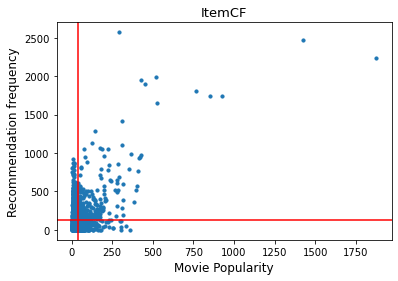

In [77]:
import matplotlib.pyplot as plt

x_popularity = list(rec_business_popular.values())
y_recommendation_frequency = list(rec_freq.values())
pop_mean = np.mean(x_popularity)
rec_mean = np.mean(y_recommendation_frequency)
plt.scatter(x_popularity, y_recommendation_frequency,s=10,marker='o')
plt.axhline(y = rec_mean, color = "r", linestyle = "-")
plt.axvline(x = pop_mean, color = "r", linestyle = "-")

plt.xlabel('Movie Popularity',fontsize=12)  
plt.ylabel('Recommendation frequency',fontsize=12)
plt.title('ItemCF', fontsize=13)

## Evaluation

## Bias-CF

In [78]:
# get average
avg_rating_overall = 0
avg_rating_users = {}
avg_rating_items = {}
for b in business_popular:
    avg_rating_items.setdefault(b, 0)

for user, businesses in dataDic.items():
    avg_rating_users.setdefault(user, 0)
    avg_rating_users[user] = np.mean(list(businesses.values()))
    avg_rating_overall += sum(businesses.values())
    
    for business in businesses:
        avg_rating_items[business] += businesses[business]

for business in avg_rating_items:
    Mean = avg_rating_items[business]/business_popular[business]
    avg_rating_items[business] = Mean

avg_rating_overall = avg_rating_overall/dataDic_len

In [79]:
# 这里先把产生推荐的那个封装成函数才能测试所有的测试样本
def recommend_rerank(aim_user, data, sim_matrix, bg, bu, bi, k=20, n=20):
    rank ={}
    rated_businesses = data[aim_user]      # 找出目标用户看到电影
    
    # 753
    w_sum = {}
    R = {}
    
    for business, rating in rated_businesses.items():
        #遍历与物品item最相似的前k个产品，获得这些物品及相似分数
        for related_business, w in sorted(sim_matrix[business].items(), key=itemgetter(1), reverse=True)[:k]:
            # 若该物品用户看过， 跳过
            if related_business in rated_businesses:
                continue

            # 计算用户user对related_business的偏好值， 初始化该值为0
            rank.setdefault(related_business, 0)
            w_sum.setdefault(related_business, 0)
            #通过与其相似物品对物品related_business的偏好值相乘并相加。
            #排名的依据—— > 推荐电影与该已看电影的相似度(累计) * 用户对已看电影的评分
            rank[related_business] += w * (rating - (bu[aim_user]+bi[business]-bg))
            w_sum[related_business] += w
    
    # 753
    for bid in rank.keys():
        rank[bid] = (rank[bid] / w_sum[bid]) + (bu[aim_user]+bi[bid]-bg)
    
    #print(rank)
    # 产生最后的推荐列表
    result =  sorted(rank.items(), key=itemgetter(1), reverse=True)[:n]  # itemgetter(1) 是简洁写法
    
    rank_position = list(range(1,len(result)+1))
    
    return result, rank_position

In [80]:
aim_user = 1202
recom_list, rank_posi = recommend_rerank(aim_user, dataDic, business_sim_matrix, avg_rating_overall, avg_rating_users, avg_rating_items,k=20,n=20)

In [81]:
recom_list

[(2328, 6.032558139534883),
 (986, 5.488372093023257),
 (1025, 5.442235558889722),
 (366, 5.389420884632925),
 (4808, 5.299522425249171),
 (3908, 5.295058139534884),
 (3129, 5.205531112507858),
 (2436, 5.14922480620155),
 (3701, 5.139647454665819),
 (35, 5.071161048689138),
 (4658, 5.046666666666667),
 (5178, 4.985507246376811),
 (1919, 4.962121212121211),
 (2192, 4.957558139534884),
 (1041, 4.940350877192982),
 (3035, 4.9289617486338795),
 (1329, 4.907752823245779),
 (6054, 4.897435897435898),
 (130, 4.868921775898521),
 (786, 4.854179761156505)]

## PRU

In [82]:
-get_SRC(recom_list, rank_posi, business_popular)

-0.17299737966548892

In [83]:
SRC_list = []
SRC = 0
pop_list = []
for uid in list(dataDic.keys()):
    #print(uid)
    recom_list, rank_posi = recommend_rerank(uid, dataDic, business_sim_matrix, avg_rating_overall, avg_rating_users, avg_rating_items, k = 20, n = 20)
    SRC = get_SRC(recom_list, rank_posi, business_popular)
    if np.isnan(SRC):
        continue
    SRC_list.append(SRC)
    
PRU = -np.mean(SRC_list)
PRU

-0.07817936263956736

## PRI

In [84]:
ave_rank = {}
rank_count = {}
pop = {}
for uid in list(dataDic.keys()):
    recom_list, rank_posi = recommend_rerank(uid, dataDic, business_sim_matrix, avg_rating_overall, avg_rating_users, avg_rating_items, k = 20, n = 20)
    for index in range(len(recom_list)):
        bid = recom_list[index][0]
        ave_rank.setdefault(bid,0)
        rank_count.setdefault(bid,0)
        ave_rank[bid] += rank_posi[index]
        rank_count[bid] += 1

for business in ave_rank:
    ave_rank[business] = ave_rank[business]/rank_count[business]
    pop.setdefault(business,0)
    pop[business] = business_popular[business]


SRC,_ = stats.spearmanr(list(ave_rank.values()), list(pop.values()))
PRI = -SRC
PRI

0.02784918387431515

## Plot frequency

In [85]:
rec_business_popular1 = business_popular
rec_freq1 = {}
for b in rec_business_popular1:
    rec_freq1.setdefault(b, 0)
    
for uid in list(dataDic.keys()):
    #print(uid)
    recom_list, _ = recommend_rerank(uid, dataDic, business_sim_matrix, avg_rating_overall, avg_rating_users, avg_rating_items,k=20,n=20)
    for rec in recom_list:
        rec_freq1[rec[0]] += 1

Text(0.5, 1.0, 'ItemCF')

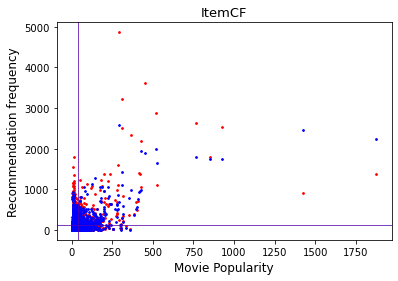

In [86]:
import matplotlib.pyplot as plt

# after
x_popularity = list(rec_business_popular1.values())
y_recommendation_frequency = list(rec_freq1.values())
pop_mean = np.mean(x_popularity)
rec_mean = np.mean(y_recommendation_frequency)
plt.scatter(x_popularity, y_recommendation_frequency,s=3,marker='o', color = 'red')
plt.axhline(y = rec_mean, color = "r", linestyle = "-",linewidth=0.5)
plt.axvline(x = pop_mean, color = "r", linestyle = "-", linewidth=0.5)

# before
x_popularity = list(rec_business_popular.values())
y_recommendation_frequency = list(rec_freq.values())
pop_mean = np.mean(x_popularity)
rec_mean = np.mean(y_recommendation_frequency)
plt.scatter(x_popularity, y_recommendation_frequency,s=3,marker='o', color = 'blue')
plt.axhline(y = rec_mean, color = "b", linestyle = "-", linewidth=0.5)
plt.axvline(x = pop_mean, color = "b", linestyle = "-", linewidth=0.5)


plt.xlabel('Movie Popularity',fontsize=12)  
plt.ylabel('Recommendation frequency',fontsize=12)
plt.title('ItemCF', fontsize=13)